In [1]:
# http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data upload

**Data Upload**

After installing all the necessary libraries and packages, we upload our data. Data represented as two numpy files. X.npy  with images and Y.npy with corresponding labels. 

In [4]:
!ls

SL_classifier.py		  X.npy		 Y_combine.npy	net.py
Sign-language-digits-dataset.zip  X_combine.npy  dataset.zip
Sign_Language_Classifier.ipynb	  Y.npy		 model_sl.pt


In [5]:
import zipfile
with zipfile.ZipFile('Sign-language-digits-dataset.zip', 'r') as f:
    f.extractall()
with zipfile.ZipFile('dataset.zip', 'r') as f:
    f.extractall()

In [6]:
X_0 = np.load("X_combine.npy")
Y = np.load("Y_combine.npy")
X_0 = np.load("X.npy")
Y = np.load("Y.npy")
print(X_0.shape, Y.shape)

(2062, 64, 64) (2062, 10)


Next, we want to see dimensions and representation of our data


In [7]:
print("Sample X: ")
print( X_0[1])
print("Sample X shape: ", X_0[1].shape)
print("Sample Y: ")
print( Y[1])
print("Sample Y shape: ", Y[1].shape)

Sample X: 
[[0.59607846 0.60784316 0.61960787 ... 0.4627451  0.4509804  0.44313726]
 [0.60784316 0.61960787 0.6313726  ... 0.4745098  0.4627451  0.4509804 ]
 [0.6156863  0.627451   0.6431373  ... 0.4862745  0.4745098  0.4627451 ]
 ...
 [0.50980395 0.5176471  0.5254902  ... 0.40392157 0.39607844 0.3882353 ]
 [0.5019608  0.50980395 0.5176471  ... 0.4        0.39215687 0.38431373]
 [0.49411765 0.5058824  0.50980395 ... 0.3882353  0.38039216 0.37254903]]
Sample X shape:  (64, 64)
Sample Y: 
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample Y shape:  (10,)



As we can see, our image represented as 64 by 64 array and labels represented as on-hot vectors. We need to convert labels to numerical labels

0


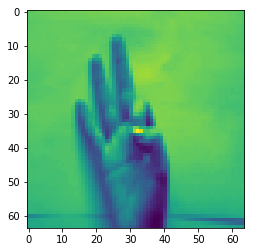

In [8]:
i = 30
Y_l= np.argmax(Y, axis=1)

Y_l.shape
plt.imshow(X_0[i])
print(Y_l[i])

We need to add an extra channel to our images to be able to use convolutional neural networks and convert our numpy arrays to Pytorch tensors.


In [9]:
# X = np.repeat(np.expand_dims(X_0, axis=1), 3, axis=1)
X = np.expand_dims(X_0, axis=1)
images = X
labels = Y_l
np.unique(Y_l)
print(images.shape, labels.shape)
print("Unique Classes: ", np.unique(Y_l))

(2062, 1, 64, 64) (2062,)
Unique Classes:  [0 1 2 3 4 5 6 7 8 9]


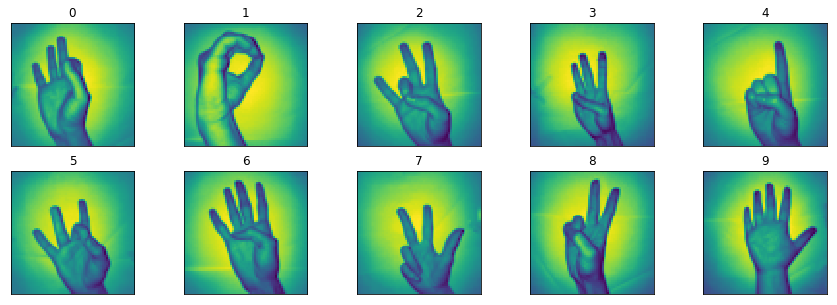

In [10]:
#Plot 10 unique classes with corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[labels.tolist().index(idx)][0])
    ax.set_title( idx)
    #ax.set_title( classes[idx])

From the previous figure we can see what our labels are not correct. To address this issue, the simplest way to assign correct value to the corresponding label, using the lookup dictionary. 

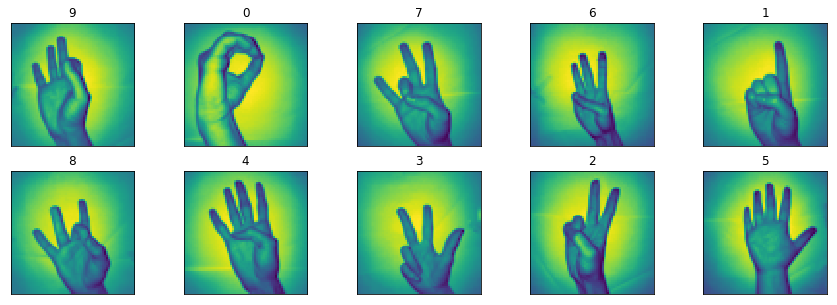

In [11]:
#The lookup dictionary.
classes = {0:9,1:0,2:7,3:6,4:1,5:8,6:4,7:3,8:2,9:5}

#Plot 10 unique classes with corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(X[Y_l.tolist().index(idx)][0])  
    ax.set_title( classes[idx])

# Check Label Distribution

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame({'label':list(Y_l)})

In [14]:
df.shape

(2062, 1)

In [15]:
df.nunique()

label    10
dtype: int64

In [16]:
df.groupby('label')['label'].count()

label
0    204
1    205
2    206
3    207
4    206
5    208
6    207
7    206
8    206
9    207
Name: label, dtype: int64

# Prepare Dataset

Now all our data is in a correct format, we can create a custom-made Dataset, where each image has a corresponding label, allowing us to shuffle, split and manipulate our dataset. 


In [17]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=14045)
images_val, images_test, labels_val, labels_test =  train_test_split(images_test, labels_test, test_size=0.5, stratify=labels_test, random_state=14045)

In [18]:
pd.DataFrame({'label':list(labels_train)}).groupby('label')['label'].count()

label
0    163
1    164
2    165
3    166
4    165
5    166
6    165
7    165
8    165
9    165
Name: label, dtype: int64

In [19]:
pd.DataFrame({'label':list(labels_val)}).groupby('label')['label'].count()

label
0    21
1    20
2    21
3    20
4    20
5    21
6    21
7    21
8    20
9    21
Name: label, dtype: int64

In [20]:
pd.DataFrame({'label':list(labels_test)}).groupby('label')['label'].count()

label
0    20
1    21
2    20
3    21
4    21
5    21
6    21
7    20
8    21
9    21
Name: label, dtype: int64

In [21]:
images_train = torch.from_numpy(images_train)
images_val = torch.from_numpy(images_val)
images_test = torch.from_numpy(images_test)

labels_train = torch.from_numpy(labels_train)
labels_val = torch.from_numpy(labels_val)
labels_test = torch.from_numpy(labels_test)

In [22]:
class Dataset(Dataset):
  #creating a custom dataset
  def __init__(self, images, labels, transforms=None):
        #init images and data
        self.images = images
        self.labels = labels
        self.transforms = transforms

  def __len__(self):
        #getting lenght of dataset
        return len(self.images)

  def __getitem__(self, idx):        
        # Select sample    
        image = self.images[idx]
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)
            
        return image, label
    
    
data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_sign_language_dataset = Dataset(images_train, labels_train, transforms=data_transforms)
val_sign_language_dataset = Dataset(images_val, labels_val, transforms=data_transforms)
test_sign_language_dataset = Dataset(images_test, labels_test, transforms=data_transforms)

print("Random sample from our dataset: ")
print(train_sign_language_dataset[1000])

Random sample from our dataset: 
(tensor([[[-0.8431, -0.8431, -0.8431,  ..., -0.0667, -0.0824, -0.8431],
         [-0.0431, -0.0196, -0.0039,  ..., -0.0588, -0.0667, -0.8431],
         [-0.0275, -0.0118,  0.0118,  ..., -0.0431, -0.0588, -0.8431],
         ...,
         [-0.8431,  0.0510,  0.0745,  ...,  0.0196, -0.0039, -0.0196],
         [-0.8431,  0.0588,  0.0667,  ...,  0.0039, -0.0118, -0.0353],
         [-0.8431,  0.0588,  0.0667,  ..., -0.8431, -0.8431, -0.8431]]]), tensor(8))


In [23]:
len(train_sign_language_dataset), len(val_sign_language_dataset), len(test_sign_language_dataset)

(1649, 206, 207)

For training our classifier we split our Dataset into training, validation and test sets, in proportion 8:1:1.

In [24]:
# initiate parameters for splitting our data
num_workers = 4
batch_size = 64

# define samplers for obtaining training, validation and test batches

# load our batches
train_loader = torch.utils.data.DataLoader(train_sign_language_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_sign_language_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_sign_language_dataset,
                                           batch_size=batch_size,                                      
                                           num_workers=num_workers)

print("Length of training set: ",len(train_loader))
print("Length of validation set: ",len(valid_loader))
print("Length of test set: ",len(test_loader))

Length of training set:  26
Length of validation set:  4
Length of test set:  4


This is our one training batch visualised. 

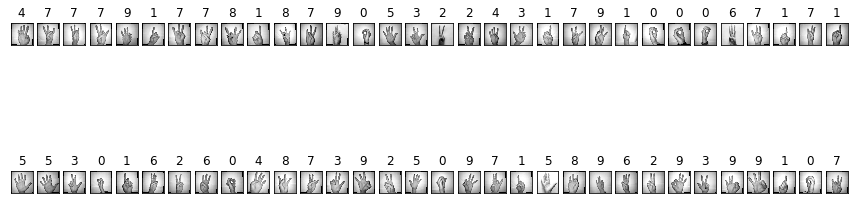

In [25]:
# obtain one batch of training images and plot these images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(15,5))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0], cmap='gray')
    ax.set_title(classes[labels.tolist()[idx]])

#Model



---


**Classifier Model**


Let us define our model, it has 3 convolutional layers with pooling and 2 fully connected layers, with dropouts and Relu activation functions.


**Train and validate our model**

1. Train

*   Initialize our loss function and optimizer
*   Run training batch 
*   Calculate the loss
*   Backpropagate
*   Update weights


2. Validate


*   Feedforward validation batch
*   Compute error
*   If validation loss decreased save our model

3.Repeat

For the number of epochs









In [30]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      
        self.conv1_1 = nn.Conv2d(1, 8, 3, padding=1)      
        self.conv1_2 = nn.Conv2d(8, 8, 3, padding=1)      
        self.conv1_3 = nn.Conv2d(8, 8, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2) 
        
        self.conv2_1 = nn.Conv2d(8, 16, 3, padding=1)      
        self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)      
        self.conv2_3 = nn.Conv2d(16, 16, 3, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2) 
        
        self.conv3_1 = nn.Conv2d(16, 32, 3, padding=1)      
        self.conv3_2 = nn.Conv2d(32, 32, 3, padding=1)      
        self.conv3_3 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.pool3 = nn.MaxPool2d(2, 2) 
        
        self.conv4_1 = nn.Conv2d(32, 64, 3, padding=1)      
        self.conv4_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4_3 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.fc1 = nn.Linear(64, 64)
        self.do = nn.Dropout(p=0.35)
        self.fc2 = nn.Linear(64, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # 64x64x1 => 32x32x8
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = self.pool1(x)
        
        # 32x32x8 => 16x16x16
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = self.pool2(x)
        
        # 16x16x16 => 8x8x32
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        
        # 8x8x32 => 8x8x10
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))

        x = self.do(self.fc1(x.view(-1, 64, 8*8).sum(dim=-1)))
        x = F.log_softmax(self.fc2(x), dim=-1)

        return x

In [31]:
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [32]:
model(torch.randn(5,1,64,64).cuda())

tensor([[ -87.1900, -104.8127, -121.8488, -193.6010, -129.1961,  -78.2749,
            0.0000, -208.3001, -134.8992, -254.8883],
        [-203.5543,  -45.2388, -140.1957, -188.6996,  -82.3916,  -23.1358,
            0.0000, -231.9440,  -65.3530, -261.2335],
        [-114.3922,    0.0000,  -37.4135,  -89.9979,  -88.3565, -117.7403,
          -18.4205, -120.5199, -153.6597, -230.0203],
        [-114.6331,   -0.0193, -149.7599, -113.7410,  -18.9629,   -3.9594,
          -48.1279,  -87.3659, -108.6836, -265.3200],
        [-147.6420,  -43.9138,  -64.2837, -149.7830, -192.1541,  -81.6101,
            0.0000, -149.4558, -186.6776, -285.6387]], device='cuda:0')

In [33]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              80
            Conv2d-2            [-1, 8, 64, 64]             584
            Conv2d-3            [-1, 8, 64, 64]             584
         MaxPool2d-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,168
            Conv2d-6           [-1, 16, 32, 32]           2,320
            Conv2d-7           [-1, 16, 32, 32]           2,320
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
           Conv2d-10           [-1, 32, 16, 16]           9,248
           Conv2d-11           [-1, 32, 16, 16]           9,248
        MaxPool2d-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          18,496
           Conv2d-14             [-1, 6

In [34]:
#loss function
criterion = nn.NLLLoss()

In [35]:
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss

base_lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=base_lr)

for epoch in range(1, n_epochs+1):
    # Update Learning Rate
    lr = base_lr * (1 / (1 + (0.1 * (epoch - 1))))
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0    
    
    # train the model    
    
    model.train()
    for data, target in train_loader:        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()       
        optimizer.zero_grad()
        output = model(data)       
        loss = criterion(output, target)
        loss.backward()       
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    # validate the model 
  
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
       
        with torch.no_grad():
            output = model(data)       
            loss = criterion(output, target)       
            valid_loss += loss.item()*data.size(0)    
   
    train_loss = train_loss/len(train_sign_language_dataset)
    valid_loss = valid_loss/len(val_sign_language_dataset)        
   
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_sl.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5.207089 	Validation Loss: 2.319333
Validation loss decreased (inf --> 2.319333).  Saving model ...
Epoch: 2 	Training Loss: 2.348641 	Validation Loss: 2.307936
Validation loss decreased (2.319333 --> 2.307936).  Saving model ...
Epoch: 3 	Training Loss: 2.318222 	Validation Loss: 2.304423
Validation loss decreased (2.307936 --> 2.304423).  Saving model ...
Epoch: 4 	Training Loss: 2.313944 	Validation Loss: 2.299629
Validation loss decreased (2.304423 --> 2.299629).  Saving model ...
Epoch: 5 	Training Loss: 2.311729 	Validation Loss: 2.298909
Validation loss decreased (2.299629 --> 2.298909).  Saving model ...
Epoch: 6 	Training Loss: 2.311457 	Validation Loss: 2.300800
Epoch: 7 	Training Loss: 2.306167 	Validation Loss: 2.296827
Validation loss decreased (2.298909 --> 2.296827).  Saving model ...
Epoch: 8 	Training Loss: 2.302900 	Validation Loss: 2.294717
Validation loss decreased (2.296827 --> 2.294717).  Saving model ...
Epoch: 9 	Training Loss: 2.301406 

Epoch: 86 	Training Loss: 0.082496 	Validation Loss: 0.215877
Epoch: 87 	Training Loss: 0.076743 	Validation Loss: 0.132254
Validation loss decreased (0.133538 --> 0.132254).  Saving model ...
Epoch: 88 	Training Loss: 0.072085 	Validation Loss: 0.217435
Epoch: 89 	Training Loss: 0.079764 	Validation Loss: 0.122442
Validation loss decreased (0.132254 --> 0.122442).  Saving model ...
Epoch: 90 	Training Loss: 0.091478 	Validation Loss: 0.228965
Epoch: 91 	Training Loss: 0.104343 	Validation Loss: 0.257319
Epoch: 92 	Training Loss: 0.099368 	Validation Loss: 0.246030
Epoch: 93 	Training Loss: 0.074355 	Validation Loss: 0.123697
Epoch: 94 	Training Loss: 0.073256 	Validation Loss: 0.145158
Epoch: 95 	Training Loss: 0.086605 	Validation Loss: 0.151471
Epoch: 96 	Training Loss: 0.068653 	Validation Loss: 0.158418
Epoch: 97 	Training Loss: 0.089831 	Validation Loss: 0.175647
Epoch: 98 	Training Loss: 0.077611 	Validation Loss: 0.153311
Epoch: 99 	Training Loss: 0.065760 	Validation Loss: 0.1

**Test the model**

Test and visualize our model.
Credits to Udasity for multi classes validation  and plotting.  [GitHub](https://github.com/udacity/deep-learning-v2-pytorch)

In [36]:
model.load_state_dict(torch.load('model_sl.pt'))

In [37]:
# track test loss
train_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    train_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Train Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Train Loss: 0.037825

Train Accuracy of     9: 98.7730% (161/163)
Train Accuracy of     0: 100.0000% (164/164)
Train Accuracy of     7: 98.7879% (163/165)
Train Accuracy of     6: 99.3976% (165/166)
Train Accuracy of     1: 100.0000% (165/165)
Train Accuracy of     8: 98.1928% (163/166)
Train Accuracy of     4: 96.3636% (159/165)
Train Accuracy of     3: 98.1818% (162/165)
Train Accuracy of     2: 99.3939% (164/165)
Train Accuracy of     5: 100.0000% (165/165)

Train Accuracy (Overall): 98.9084% (1631/1649)


In [38]:
# track test loss
val_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
val_loss = val_loss/len(valid_loader.dataset)
print('Valid Loss: {:.6f}\n'.format(val_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Valid Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Valid Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nValid Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Valid Loss: 0.313996

Valid Accuracy of     9: 98.7730% (161/163)
Valid Accuracy of     0: 99.3902% (163/164)
Valid Accuracy of     7: 99.3939% (164/165)
Valid Accuracy of     6: 100.0000% (166/166)
Valid Accuracy of     1: 99.3939% (164/165)
Valid Accuracy of     8: 98.1928% (163/166)
Valid Accuracy of     4: 95.7576% (158/165)
Valid Accuracy of     3: 98.7879% (163/165)
Valid Accuracy of     2: 100.0000% (165/165)
Valid Accuracy of     5: 100.0000% (165/165)

Valid Accuracy (Overall): 98.9691% (1632/1649)


In [39]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
   
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.tolist()[i]
        class_correct[label] += correct_tensor.tolist()[i]
        class_total[label] += 1

# # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.4f%% (%d/%d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.4f%% (%d/%d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

Test Loss: 0.072448

Test Accuracy of     9: 100.0000% (20/20)
Test Accuracy of     0: 95.2381% (20/21)
Test Accuracy of     7: 100.0000% (20/20)
Test Accuracy of     6: 100.0000% (21/21)
Test Accuracy of     1: 100.0000% (21/21)
Test Accuracy of     8: 85.7143% (18/21)
Test Accuracy of     4: 90.4762% (19/21)
Test Accuracy of     3: 90.0000% (18/20)
Test Accuracy of     2: 100.0000% (21/21)
Test Accuracy of     5: 100.0000% (21/21)

Test Accuracy (Overall): 96.1353% (199/207)


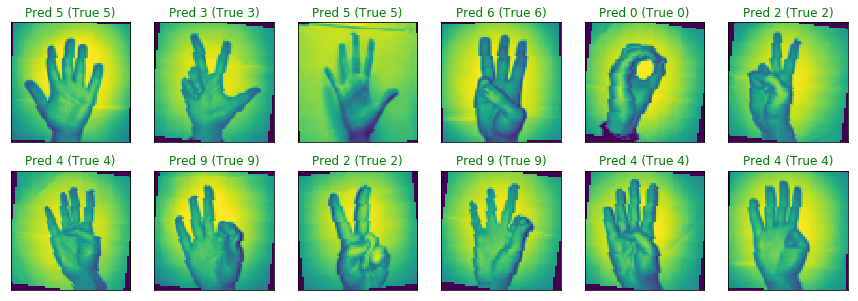

In [40]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15,5))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0])
    ax.set_title("Pred {} (True {})".format(classes[preds[idx].tolist()], classes[labels[idx].tolist()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))